In [49]:
#import libraries
import math
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Concatenate
from keras import optimizers
from keras.utils import plot_model
import matplotlib.pyplot as plt
from ta.utils import dropna
from supertrend import ST
pd.options.mode.chained_assignment = None

In [50]:
def read_csv(csv_path):
    data = pd.read_csv(csv_path)
    data = dropna(data)
    data = pd.DataFrame(data.values[::-1], data.index, data.columns)
    return data

In [108]:
DAILY = True
if DAILY == True:
    data = read_csv('ERX_daily.csv')
else:
    data = read_csv('AMZNintraday.csv')
print(data.head())

         date 1. open 2. high 3. low 4. close    5. volume
0  2008-11-19   47.79    50.8  40.71       41       560804
1  2008-11-20   39.98   39.98  26.63     27.1       854492
2  2008-11-21   29.89   36.73     28    36.23  1.12519e+06
3  2008-11-24    40.1   45.88  36.42    42.29  1.10799e+06
4  2008-11-25   44.29   46.16  40.72       44       601759


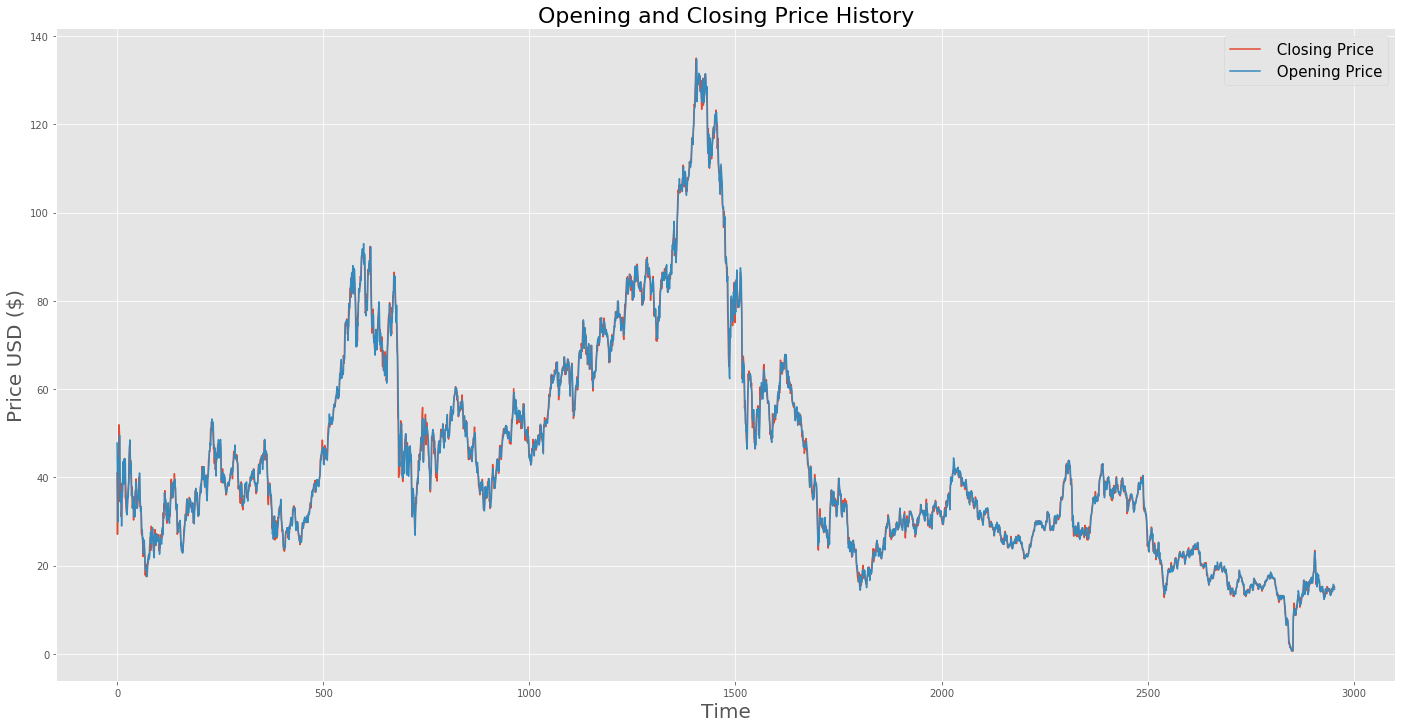

In [109]:
plt.style.use('ggplot')
plt.figure(figsize=(24,12))
plt.title('Opening and Closing Price History', fontsize=22)
plt.plot(data['4. close'], label=' Closing Price')
plt.plot(data['1. open'], label=' Opening Price')
plt.xlabel('Time',fontsize=20)
plt.ylabel('Price USD ($)',fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [110]:
#Extracting the data to be trained upon
close_data = data.filter(['4. close'])
dataset = close_data.values
train_len = math.ceil(len(dataset)*0.85)
# train_len
print(close_data)

     4. close
0          41
1        27.1
2       36.23
3       42.29
4          44
...       ...
2949     15.2
2950    15.08
2951    15.41
2952    14.81
2953     15.1

[2954 rows x 1 columns]


In [111]:
#Normalising the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
# scaled_data
O_scaler = MinMaxScaler(feature_range=(0,1))
scaled_output = O_scaler.fit_transform(np.reshape(dataset[:,0],(dataset.shape[0],1)))

In [112]:
history = 40 # number of data points to be used for prediction
train_data = scaled_data[0:train_len]
test_data = scaled_data[train_len-history:]
print(train_data.shape,test_data.shape)

(2511, 1) (483, 1)


In [113]:
# Creating the training data
x_train = []
y_train = []
for x in range(history,len(train_data)):
    x_train.append(train_data[x-history:x])
    y_train.append(train_data[x,0])
x_train,y_train = np.array(x_train),np.array(y_train)

x_test = []
for x in range(history,len(test_data)):
    x_test.append(test_data[x-history:x])
x_test = np.array(x_test)
y_test = dataset[train_len:,0]

y_train = np.reshape(y_train,(y_train.shape[0],1))
y_test = np.reshape(y_test,(y_test.shape[0],1))
y_train.shape

(2471, 1)

In [114]:
def model_daily(x_train):
    #Building the model
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())

    model.add(LSTM(units=64, return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())

    model.add(Dense(units=32))
    # model.add(BatchNormalization())
    model.add(Dense(units=1))
    
    #Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

In [123]:
if DAILY == True:
    model = model_daily(x_train)
    hist = model.fit(x_train, y_train, batch_size=1, epochs=30, validation_split = 0.05)

Train on 2347 samples, validate on 124 samples
Epoch 1/30
2347/2347 [==============================] - 34s 15ms/step - loss: 0.0015 - val_loss: 1.5406e-04
Epoch 2/30
2347/2347 [==============================] - 36s 15ms/step - loss: 6.4496e-04 - val_loss: 2.0200e-04
Epoch 3/30
2347/2347 [==============================] - 34s 14ms/step - loss: 5.6879e-04 - val_loss: 1.7281e-04
Epoch 4/30
2347/2347 [==============================] - 34s 15ms/step - loss: 5.3510e-04 - val_loss: 9.4123e-05
Epoch 5/30
2347/2347 [==============================] - 34s 15ms/step - loss: 4.3958e-04 - val_loss: 1.0736e-04
Epoch 6/30
2347/2347 [==============================] - 34s 14ms/step - loss: 4.8038e-04 - val_loss: 8.7758e-05
Epoch 7/30
2347/2347 [==============================] - 34s 14ms/step - loss: 4.1266e-04 - val_loss: 9.0875e-05
Epoch 8/30
2347/2347 [==============================] - 34s 14ms/step - loss: 4.0682e-04 - val_loss: 1.5071e-04
Epoch 9/30
2347/2347 [==============================] - 34s 1

In [124]:
if DAILY == True:
    predictions = model.predict(x_test)
    predictions = O_scaler.inverse_transform(predictions)
    print(y_test.shape)

(443, 1)


In [125]:
#Find Error
real_rmse = np.sqrt(np.mean(np.square(y_test - predictions)))
print(real_rmse)

0.9475605825613984


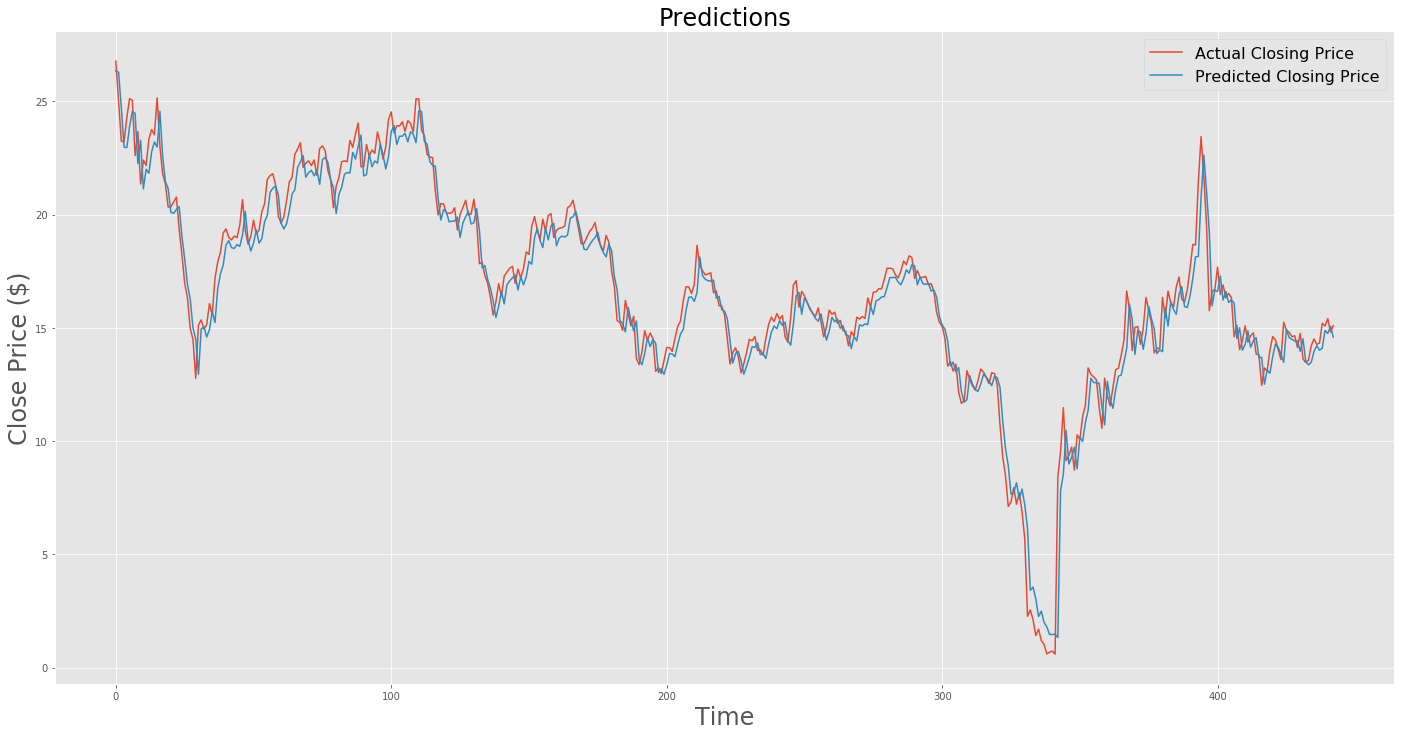

In [126]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
ground_truth = np.expand_dims(ground_truth[:,0],-1)
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(predictions, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()

In [127]:
def save_model(name):
    model.save(name+".h5")
    print("model saved")

In [128]:
save_model('ERX')
print(data.tail())
last = x_test[-1]
last = np.reshape(last,(1,last.shape[0],last.shape[1]))
last.shape
next_day = model.predict(last)
next_day = O_scaler.inverse_transform(next_day)
next_day

model saved
            date 1. open 2. high   3. low 4. close    5. volume
2949  2020-08-10    14.5  15.215    14.46     15.2  4.41543e+06
2950  2020-08-11   15.76   16.16  14.9504    15.08  6.88326e+06
2951  2020-08-12   15.59   15.75    15.08    15.41  5.02839e+06
2952  2020-08-13    15.2   15.41    14.74    14.81   3.5184e+06
2953  2020-08-14    14.6   15.13  14.4675     15.1  3.63377e+06


array([[14.587398]], dtype=float32)

In [21]:
#USing Technical Indicators
data['ADX'] = ta.trend.adx(data['2. high'], data['3. low'], data['4. close'], n = 20, fillna = True)
data['MACD'] = ta.trend.macd(data['4. close'], n_fast = 26 , n_slow = 12, fillna = True)
data['SMA'] = ta.trend.sma_indicator(data['4. close'], n = 10, fillna = True)
# data = ST(data,3,7)
# data = dropna(data)
data.head()

,date,1. open,2. high,3. low,4. close,5. volume,ADX,MACD,SMA
0,1999-11-01,68.06,71.88,66.31,69.13,1.28241e+07,0.0,0.000000,69.130000
1,1999-11-02,69.75,70,65.06,66.44,1.32432e+07,0.0,0.214587,67.785000
2,1999-11-03,68.19,68.5,65,65.81,1.07721e+07,0.0,0.430522,67.126667
3,1999-11-04,67.19,67.19,61,63.06,1.67592e+07,0.0,0.814168,66.110000
4,1999-11-05,64.75,65.5,62.25,64.94,1.10914e+07,0.0,0.955496,65.876000


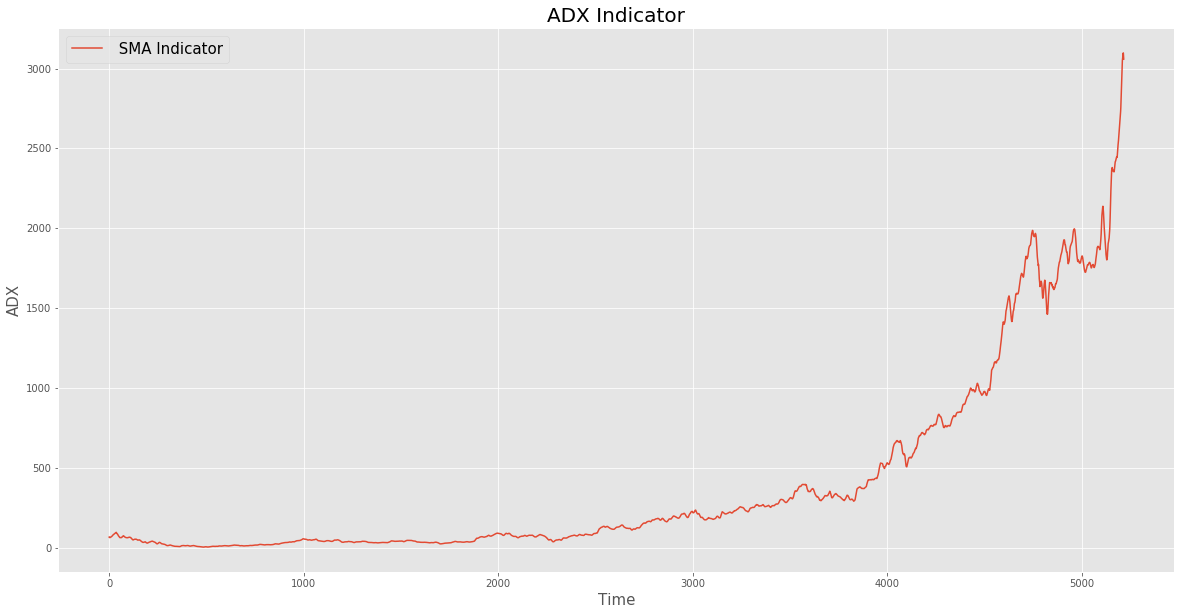

In [20]:
plt.figure(figsize = (20,10))
plt.title('ADX Indicator',fontsize = 20)
# plt.plot(data['ADX'],label = 'ADX Indicator')
# plt.plot(data['MACD'], label = 'MACD Indicator')
plt.plot(data['SMA'], label = ' SMA Indicator')
# plt.plot(data['SuperTrend'], label = ' SuperTrend Indicator')
plt.xlabel('Time',fontsize = 15)
plt.ylabel('ADX',fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [22]:
#Scaling Technical Indicator
tech_ind_scaler = MinMaxScaler(feature_range=(0,1))
tech_ind_value = data.filter(['ADX']).values
scaled_tech_ind = tech_ind_scaler.fit_transform(tech_ind_value)
scaled_tech_ind

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.73346044],
       [0.72605676],
       [0.71057814]])

In [23]:
tech_ind_train = scaled_tech_ind[history:train_len]
tech_ind_test = scaled_tech_ind[train_len:]
tech_ind_test.shape

(782, 1)

In [31]:
#Building concatenated model
def model_intraday(x_train,tech_ind_train):
    model_1 = Sequential()
    model_1.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1:])))
    # model_1.add(BatchNormalization())
#     model_1.add(Dropout(0.2))


    model_1.add(LSTM(units=64, return_sequences=False))
    # model_1.add(BatchNormalization())
    # model_1.add(Dropout(0.2))
    # model_1.add(LSTM(units = 56,return_sequences = False))

    model_2 = Sequential()
    model_2.add(Dense(units = 32, input_shape=(tech_ind_train.shape[1],)))
    # model_2.add(BatchNormalization())
#     model_2.add(Dropout(0.4))
    # model_2.add(Dense(units = 64, activation = 'relu'))

    concat = Concatenate()([model_1.output,model_2.output])

    output = Dense(64,activation = 'linear')(concat)
    output = Dense(1,activation = 'sigmoid')(output)

    model = Model([model_1.input,model_2.input],output)

    plot_model(model, show_shapes=True)
    
    #Compile the model
    opt = optimizers.Adam(lr=0.0005)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [32]:
if DAILY == True:
    model = model_intraday(x_train,tech_ind_train)
    hist = model.fit([x_train,tech_ind_train], y_train, batch_size=25,epochs=50, validation_split = 0.05)

Train on 4174 samples, validate on 220 samples
Epoch 1/50
4174/4174 [==============================] - 17s 4ms/step - loss: 0.0105 - val_loss: 0.0679
Epoch 2/50
4174/4174 [==============================] - 17s 4ms/step - loss: 0.0047 - val_loss: 0.0678
Epoch 3/50
4174/4174 [==============================] - 18s 4ms/step - loss: 0.0031 - val_loss: 0.0481
Epoch 4/50
4174/4174 [==============================] - 17s 4ms/step - loss: 0.0028 - val_loss: 0.0458
Epoch 5/50
4174/4174 [==============================] - 17s 4ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 6/50
4174/4174 [==============================] - 16s 4ms/step - loss: 9.2744e-05 - val_loss: 0.0012
Epoch 7/50
4174/4174 [==============================] - 16s 4ms/step - loss: 7.6021e-05 - val_loss: 7.7394e-04
Epoch 8/50
4174/4174 [==============================] - 17s 4ms/step - loss: 4.8459e-05 - val_loss: 6.0320e-04
Epoch 9/50
4174/4174 [==============================] - 17s 4ms/step - loss: 4.4822e-05 - val_loss: 5.5099e-0

In [33]:
if DAILY == True:
    print(x_test.shape,tech_ind_test.shape)
    predictions = model.predict([x_test,tech_ind_test])
    predictions = O_scaler.inverse_transform(predictions)

(782, 40, 1) (782, 1)


In [34]:
#Find Error
real_mse = np.mean(np.square(y_test - predictions))
real_mse

141474.98854404155

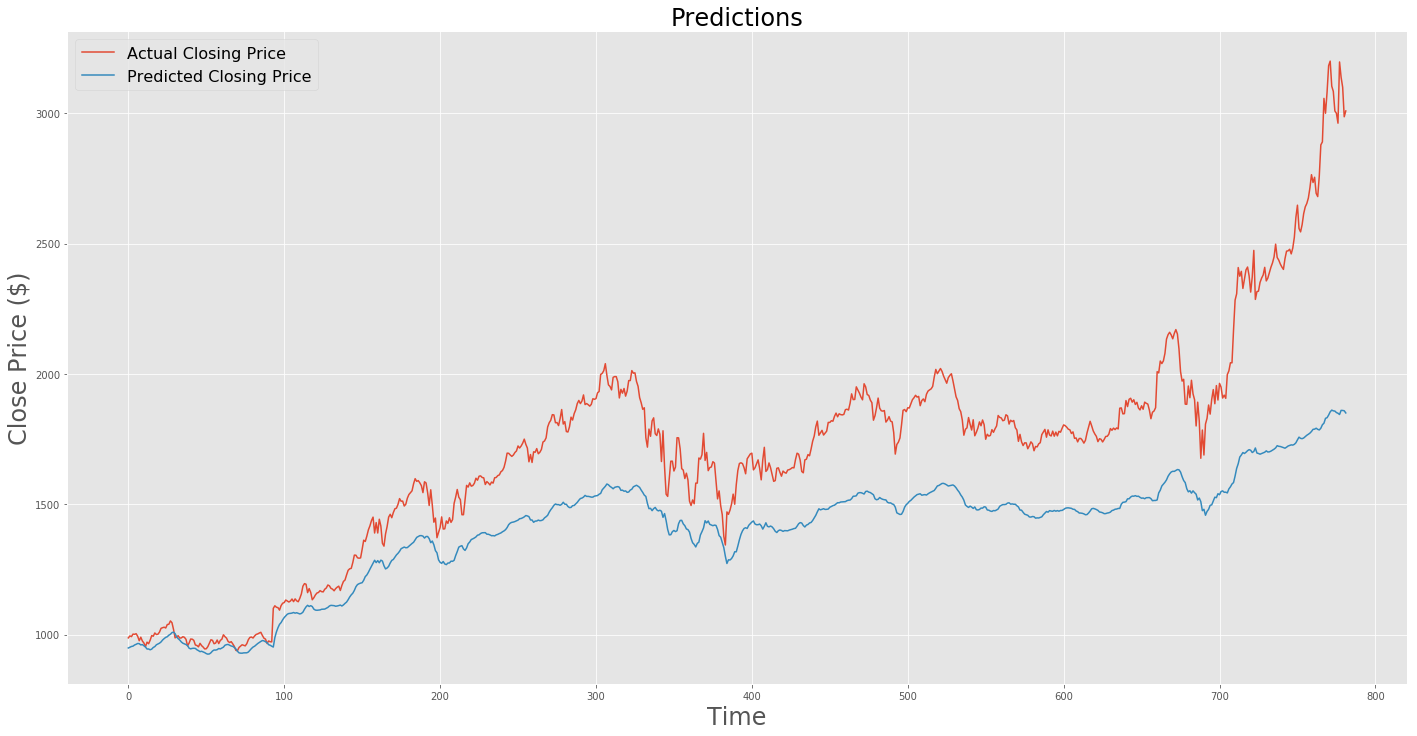

In [35]:
#plotting the results
ground_truth = np.array(close_data[train_len:])
ground_truth = np.expand_dims(ground_truth[:,0],-1)
plt.figure(figsize=(24,12))
plt.title('Predictions',fontsize = 24)
plt.xlabel('Time', fontsize=24)
plt.ylabel('Close Price ($)', fontsize=24)
plt.plot(ground_truth, label = "Actual Closing Price")
plt.plot(predictions, label = "Predicted Closing Price")
plt.legend(fontsize = 16)
plt.show()